# Title

### Wormhole


### Terra Bridge




### Objective

As Wormhole has added Terra support with the Columbus 5 upgrade, analyze the initial activity: 
* How many users are engaging, what tokens are they receiving vs sending? 
* Which destinations/sources are most popular? 
* What is the adoption rate, i.e. how rapidly are users choosing to use Wormhole over the Terra-specific Bridge? 
* Anything else you observe of interest?


### Data


### Query
The query used to retrieve the relevant data can be found [here](https://app.flipsidecrypto.com/velocity/queries/5027ee2e-4de7-41dd-8686-072046b3ce8b). Some main points to highlight:
* 
* 
* 

## Transactions
* Number of total transactions
* Number of daily transactions over time

In [647]:
wh_receive_.tx_id.count() + wh_send.tx_id.count()

5848

<AxesSubplot:xlabel='month_day'>

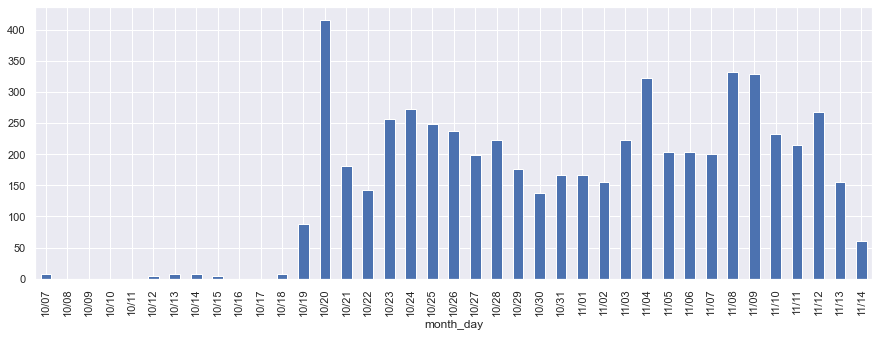

In [648]:
tot_daily_txs = wh_send[['month_day', 'tx_id']].append(wh_receive_[['month_day', 'tx_id']])
daily_tx = add_missing_days(tot_daily_txs.groupby("month_day").tx_id.count())
daily_tx.plot(kind='bar')

In [649]:
daily_tx.mean()

149.94871794871796

In [650]:
daily_tx[daily_tx.index > '10/18'].mean()

215.1851851851852

## Distinct address
* Number of distinct users sending or receiving in total. What about over time? Any increase?

In [651]:
tot_unique_addr = wh_send[['month_day', 'sender']].append(wh_receive_[['month_day', 'sender']])

In [652]:
len(tot_unique_addr.sender.unique())

1908

daily_unique_addresses = add_missing_days(tot_unique_addr.groupby("month_day").sender.nunique())
ax = daily_unique_addresses.plot(kind='bar')
ax.set_xlabel("day")
ax.set_ylabel("n of transactions")

[]

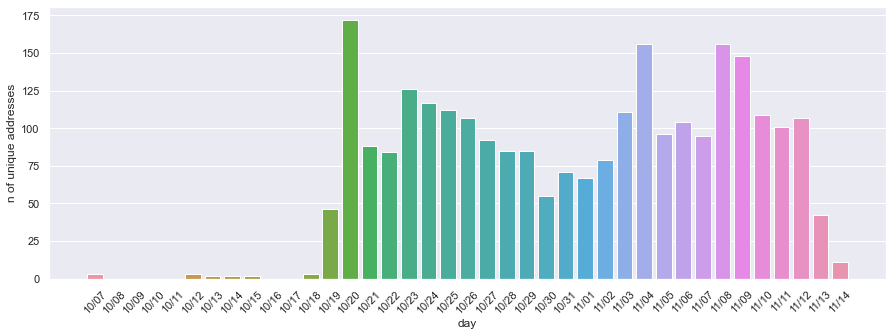

In [794]:
plt.xticks(rotation=45)
ax = sns.barplot(daily_unique_addresses.index, daily_unique_addresses.values)
ax.set(ylabel='n of unique addresses', xlabel='day')
ax.plot()

In [655]:
daily_unique_addresses.mean()

67.61538461538461

In [656]:
daily_unique_addresses[daily_unique_addresses.index > '10/18'].mean()

97.11111111111111

## Tokens
* What tokens have been sent/received?
* What tokens are most popular?

In [797]:
token_txs = pd.concat([wh_receive_.token_name.value_counts(), wh_send.token_name.value_counts()], axis=1).fillna(0)

In [798]:
token_amounts = pd.concat([wh_receive_.groupby("token_name").amount.sum(), wh_send.groupby("token_name").amount.sum()], axis=1).fillna(0)

In [799]:
tot_tokens.token_name.unique()

array(['uusd', 'uluna', 'whWETH_Ethereum', 'whUSDT_Ethereum', 'wh_Solana',
       'whSOL_Solana', 'whETH_Solana', 'whMIR_BSC', 'MINE_Terra',
       'MIR_Terra', 'ANC_Terra', 'whORION_Solana', 'whWBTC_Ethereum',
       'ORION_Terra', 'whWBNB_BSC', 'whUSDT_Polygon', 'whUST_Polygon',
       'whLUNA_Polygon', 'whUSDT_BSC', 'whUSDC_Polygon', 'whATOM_BSC',
       '"uluna"', '"uusd"', ''], dtype=object)

[Text(0, 0.5, 'n of transactions'), Text(0.5, 0, 'asset transferred')]

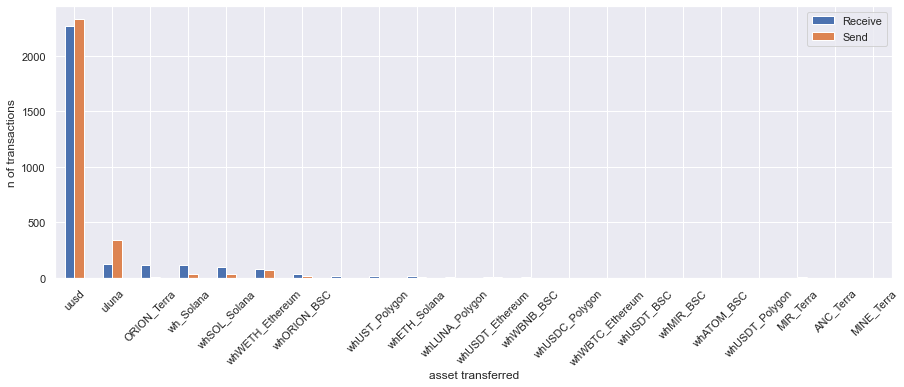

In [801]:
token_txs.columns = ['Receive','Send']
ax = token_txs.plot(kind='bar', rot=45)
ax.set(ylabel='n of transactions', xlabel='asset transferred')

[Text(0, 0.5, 'total of amount transferred'), Text(0.5, 0, 'asset')]

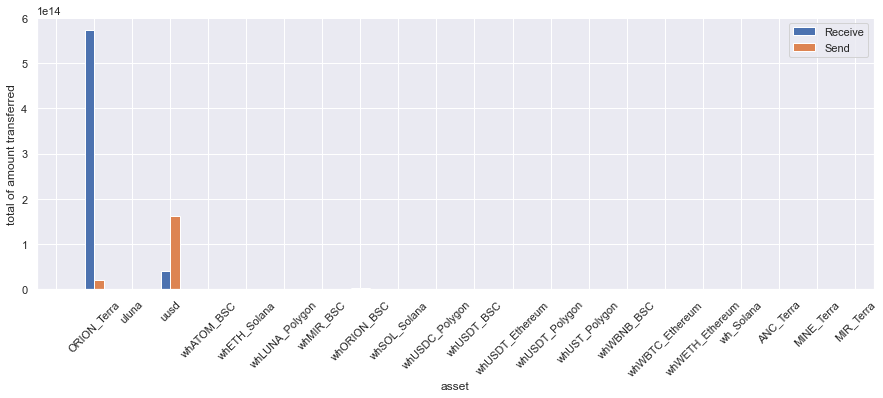

In [804]:
token_amounts.columns = ['Receive','Send']
ax = token_amounts.plot(kind='bar', rot=45)
ax.set(ylabel='total of amount transferred', xlabel='asset')

In [662]:
wh_receive_.sort_values(by="amount", ascending=False).head()

,amount,block_timestamp,recipient,sender,tx_id,token_name,month_day
226,406000000000000,2021-11-02 20:40:03+00:00,"""terra1w5l9ggryqy8q49pyfl9gqrfwdugynmd09xvwlk""","""terra1w5l9ggryqy8q49pyfl9gqrfwdugynmd09xvwlk""",1060A41659F5B72523815A0AD888AF69FA729EF722D06239400C2D8A80A48798,ORION_Terra,11/02
521,14285714285714,2021-11-09 00:45:20+00:00,"""terra15ly4zprkshh73k59g6ssdf3027zl6nd59rljpe""","""terra15ly4zprkshh73k59g6ssdf3027zl6nd59rljpe""",9BC236FB9B447BCC445BC4E2DFCE9826AC2A577FADBD4F00527DE7CC7C81165B,ORION_Terra,11/09
358,13356283590000,2021-11-09 14:37:01+00:00,"""terra12chw9xgz3wg6q50vtqru932n095pyt4lwxg97c""","""terra12chw9xgz3wg6q50vtqru932n095pyt4lwxg97c""",5A0888B65EE2815AAB30467A833597FD1C27B6AE86418EB879871EC46B3398A3,ORION_Terra,11/09
461,8534334894831,2021-11-09 00:33:47+00:00,"""terra15ly4zprkshh73k59g6ssdf3027zl6nd59rljpe""","""terra15ly4zprkshh73k59g6ssdf3027zl6nd59rljpe""",FF43F3079405E45E72AC5934CF9929564F838292144DEAF560B74FE381534148,ORION_Terra,11/09
484,7219664201897,2021-11-08 16:28:20+00:00,"""terra18j3a6pjzatdy5fhxlmnh4jlwlgg63rs0zz8t5f""","""terra18j3a6pjzatdy5fhxlmnh4jlwlgg63rs0zz8t5f""",33F64FCA1CD7B9263DB93DF0C93754C25709F990600ABE8233C7D6EC08DDF6B8,ORION_Terra,11/08


[Text(0, 0.5, 'total of amount transferred'), Text(0.5, 0, 'asset')]

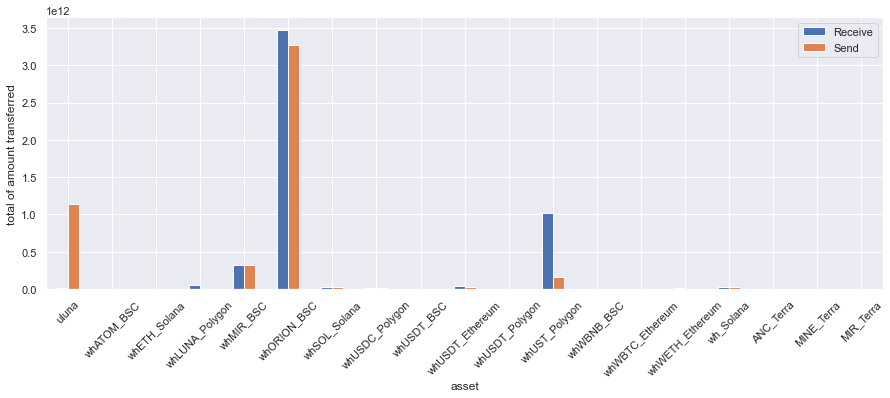

In [805]:
ax = token_amounts[(token_amounts.index != 'ORION_Terra') & (token_amounts.index != '')\
                       & (token_amounts.index != 'uusd')].plot(kind='bar', rot=45)
ax.set(ylabel='total of amount transferred', xlabel='asset')

## UST transactions
* Average amount of ust sent/received per day

In [664]:
wh_receive_ust = wh_receive_[wh_receive_.token_name == 'uusd']
wh_send_ust = wh_send[wh_send.token_name == 'uusd']

In [665]:
f"{wh_send_ust.amount.sum()/1000000/1000000} millions"

'161.614850616342 millions'

In [666]:
f"{wh_receive_ust.amount.sum()/1000000/1000000} millions"

'40.832040751038 millions'

In [667]:
(wh_send_ust.amount/1000000).describe().apply(lambda x: format(x, 'f'))

count        2328.000000
mean        69422.186691
std       1261317.712765
min             0.000001
25%            20.000000
50%           410.000000
75%          3135.000000
max      41999990.000000
Name: amount, dtype: object

In [668]:
wh_receive_ust[wh_receive_ust.amount < (wh_receive_ust.amount/1000000).quantile([.90]).iloc[0]].amount.mean()

5818.4324324324325

In [669]:
wh_send_ust[wh_send_ust.amount < (wh_send_ust.amount/1000000).quantile([.90]).iloc[0]].amount.mean()

7779.0

#### Observations:
* Obs1
* Obs2
* Obs3

## Chains
* Transaction per chain, and overtime
* Any increase in usage for some chains? What about ratio wise on all txs

In [672]:
tot_unique_addr = wh_send[['month_day', 'sender']].append(wh_receive_[['month_day', 'sender']])

In [807]:
wh_send["recipient_chain_name"]=wh_send.recipient_chain.apply(lambda x: chain_ids[x-1])

/Users/alexincerti/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


[Text(0, 0.5, 'n of transactions (per day)'), Text(0.5, 0, 'day')]

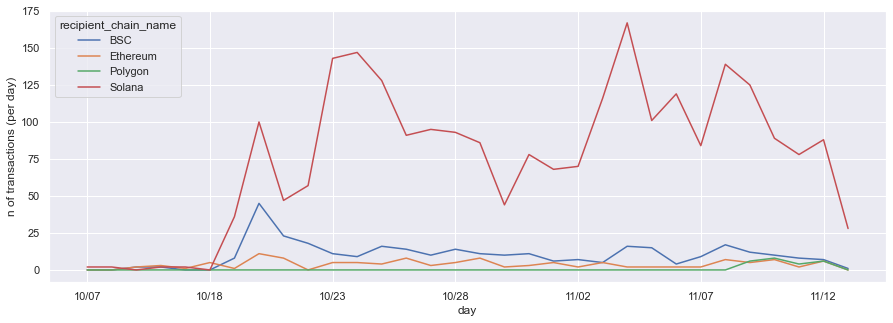

In [809]:
ax = wh_send.groupby(["recipient_chain_name","month_day"]).count().reset_index()\
    .pivot(index='month_day', columns='recipient_chain_name', values='tx_id')\
    .fillna(0)\
    .reset_index()\
    .set_index("month_day").plot(kind="line")
ax.set(ylabel='n of transactions (per day)', xlabel='day')

### Most active addresses

In [780]:
fields = ['block_timestamp', 'address', 'amount', 'token_name']
wh_send.rename(columns={'sender':'address'}, inplace=True)
wh_receive_['address'] = wh_receive.apply(lambda row: row.recipient if row.original_sender == 'terra10nmmwe8r3g99a9newtqa7a75xfgs2e8z87r2sf'\
                     else row.original_sender, axis=1)
token_addr = wh_receive_[fields].append(wh_send[fields])

[]

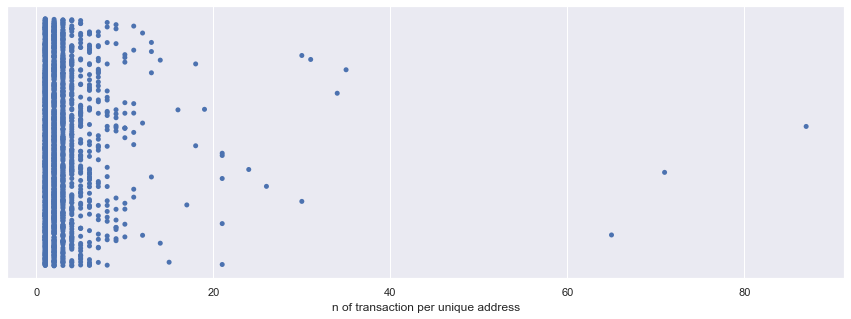

In [790]:
ax = sns.stripplot(token_addr.address.value_counts())
ax.set(xlabel='n of transaction per unique address')
ax.plot()

In [787]:
token_addr.address.value_counts().describe()

count    2249.000000
mean        2.600267
std         3.798860
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        87.000000
Name: address, dtype: float64

Terra bridge - send:
  - https://api.flipsidecrypto.com/api/v2/queries/e6369cbf-6ea1-4d84-9e45-38ad88caea73/data/latest

Terra bridge - receive:
  - ETH: https://api.flipsidecrypto.com/api/v2/queries/a1688e27-7fcf-44ad-b849-e61dd638d8e1/data/latest
  - Others 1: https://api.flipsidecrypto.com/api/v2/queries/f6ac0f33-eaee-4983-82c3-7bba1ccc0bc2/data/latest
  - Others 2: https://api.flipsidecrypto.com/api/v2/queries/f566ad03-b305-448c-8a14-7908c0bfa7d7/data/latest  

In [ ]:
tb_chains = {
    "terra13yxhrk08qvdf5zdc9ss5mwsg5sf7zva9xrgwgc":"Ethereum",
    "terra1g6llg3zed35nd3mh9zx6n64tfw3z67w2c48tn2": "BSC",
    "terra1rtn03a9l3qsc0a9verxwj00afs93mlm0yr7chk": "Harmony"
}

In [ ]:
url_tb_send = 'https://api.flipsidecrypto.com/api/v2/queries/e6369cbf-6ea1-4d84-9e45-38ad88caea73/data/latest'
url_tb_receive_eth = 'https://api.flipsidecrypto.com/api/v2/queries/a1688e27-7fcf-44ad-b849-e61dd638d8e1/data/latest'
url_tb_receive_others1 = 'https://api.flipsidecrypto.com/api/v2/queries/f6ac0f33-eaee-4983-82c3-7bba1ccc0bc2/data/latest'
url_tb_receive_others2 = 'https://api.flipsidecrypto.com/api/v2/queries/f566ad03-b305-448c-8a14-7908c0bfa7d7/data/latest'


In [ ]:
tb_send_raw = pd.read_json(url_tb_send)
tb_receive_eth_raw = pd.read_json(url_tb_receive_eth)
tb_receive_others1_raw = pd.read_json(url_tb_receive_others1)
tb_receive_others2_raw = pd.read_json(url_tb_receive_others2)

In [ ]:
tb_send_raw = pd.read_json(url_tb_send)

In [ ]:
tb_send.columns = [x.lower() for x in tb_send.columns]
tb_send.block_timestamp = pd.to_datetime(tb_send.block_timestamp)
tb_send.denom=tb_send.denom.apply(lambda x: x.replace("\"","") if x else '')
tb_send.from_address=tb_send.from_address.apply(lambda x: x.replace("\"","") if x else '')
tb_send.to_address=tb_send.to_address.apply(lambda x: x.replace("\"","") if x else '')
tb_send['to_chain'] = tb_send.to_address.apply(lambda x: tb_chains[x] if x in tokens else '')

## Data preparation

**Imports**

In [763]:
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None
matplotlib.rcParams['figure.figsize'] = (15.0, 5.0)
pd.set_option('display.max_columns', 120)
pd.options.display.max_colwidth = 10000

In [764]:
url_wh_receive = 'https://api.flipsidecrypto.com/api/v2/queries/657279fb-8a07-4089-bf08-307fb7f1325d/data/latest'
url_wh_receive_tokens = 'https://api.flipsidecrypto.com/api/v2/queries/f5ee257d-91d9-4a1d-a3e3-c2cd14f7790b/data/latest'
url_wh_send = 'https://api.flipsidecrypto.com/api/v2/queries/6cecbc05-4540-4c33-9557-585aec1af791/data/latest'

In [765]:
wh_receive_raw = pd.read_json(url_wh_receive)
wh_receive_token_raw = pd.read_json(url_wh_receive_tokens)
wh_send_raw = pd.read_json(url_wh_send)

**Preparation**

In [766]:
wh_receive = wh_receive_raw[['AMOUNT', 'BLOCK_TIMESTAMP', 'CHAIN_ID',
       'DENOM', 'ORIGINAL_SENDER', 'RECIPIENT', 'SENDER',
       'TX_ID', 'TX_MODULE', 'TX_STATUS', 'TX_TYPE']]
wh_receive = wh_receive[wh_receive.TX_STATUS == 'SUCCEEDED']
wh_receive.columns = [s.lower() for s in wh_receive.columns]
wh_receive.block_timestamp = pd.to_datetime(wh_receive.block_timestamp)
wh_receive['month_day'] = wh_receive.block_timestamp.apply(lambda b: f"{b.month}/{'{:02}'.format(b.day)}")
wh_receive.denom=wh_receive.denom.apply(lambda x: x.replace("\"","") if x else '')
wh_receive.recipient=wh_receive.recipient.apply(lambda x: x.replace("\"","") if x else '')
wh_receive.original_sender=wh_receive.original_sender.apply(lambda x: x.replace("\"","") if x else '')
wh_receive['token_name'] = wh_receive.apply(lambda r: r.denom if r.denom else '', axis=1)

In [767]:
wh_receive_token = wh_receive_token_raw[['AMOUNT', 'BLOCK_TIMESTAMP','RECIPIENT', 'TOKEN_ADDRESS', 'TX_ID', 'TX_STATUS']]
wh_receive_token = wh_receive_token[wh_receive_token.TX_STATUS == 'SUCCEEDED']
wh_receive_token.columns = [s.lower() for s in wh_receive_token.columns]
wh_receive_token.token_address=wh_receive_token.token_address.apply(lambda x: x.replace("\"","") if x else '')
wh_receive_token['token_name'] = wh_receive_token.token_address.apply(lambda x: 
                                            f"{tokens[x]['symbol']}_{chain_ids[tokens[x]['asset_chain']-1]}" if x in tokens else '')

wh_receive_token.block_timestamp = pd.to_datetime(wh_receive_token.block_timestamp)
wh_receive_token['month_day'] = wh_receive_token.block_timestamp.apply(lambda b: f"{b.month}/{'{:02}'.format(b.day)}")


In [768]:
r1 = wh_receive[['amount', 'block_timestamp',
       'recipient', 'original_sender', 'sender', 'tx_id',
       'token_name', 'month_day']]

In [769]:
r2 = wh_receive_token[['amount', 'block_timestamp', 'recipient', 'tx_id',
       'token_name', 'month_day']]
r2['sender'] = r2.recipient
r2['original_sender'] = r2.recipient

In [770]:
wh_receive_ = r1.append(r2)

In [771]:
wh_send_raw = wh_send_raw[wh_send_raw.TX_STATUS == 'SUCCEEDED']
wh_send = wh_send_raw[['BLOCK_TIMESTAMP',
       'MSG_VALUE:EXECUTE_MSG:INITIATE_TRANSFER:ASSET:AMOUNT',
       'MSG_VALUE:EXECUTE_MSG:INITIATE_TRANSFER:ASSET:INFO:NATIVE_TOKEN:DENOM',
       'MSG_VALUE:EXECUTE_MSG:INITIATE_TRANSFER:ASSET:INFO:TOKEN:CONTRACT_ADDR',
       'MSG_VALUE:EXECUTE_MSG:INITIATE_TRANSFER:RECIPIENT_CHAIN',
       'MSG_VALUE:SENDER', 'TX_ID']]
wh_send.columns = ['block_timestamp',
       'amount',
       'denom',
       'token_contract_addr',
       'recipient_chain',
       'sender', 'tx_id']
wh_send.block_timestamp = pd.to_datetime(wh_send.block_timestamp)
wh_send.token_contract_addr=wh_send.token_contract_addr.apply(lambda x: x.replace("\"","") if x else '')
wh_send.denom=wh_send.denom.apply(lambda x: x.replace("\"","") if x else '')
wh_send.amount=wh_send.amount.apply(lambda x: x.replace("\"","") if x else '').astype('int64')
wh_send.sender=wh_send.sender.apply(lambda x: x.replace("\"","") if x else '')
wh_send['token_addr_name'] = wh_send.token_contract_addr.apply(lambda x: 
                                            f"{tokens[x]['symbol']}_{chain_ids[tokens[x]['asset_chain']-1]}" if x in tokens else '')
wh_send['token_name'] = wh_send.apply(lambda r: r.denom if r.denom else r.token_addr_name, axis=1)
wh_send['month_day'] = wh_send.block_timestamp.apply(lambda b: f"{b.month}/{'{:02}'.format(b.day)}")

In [772]:
def add_missing_days(s):
    missing_days = ['10/08','10/09','10/10','10/11','10/16','10/17']
    for day in missing_days:
        s[day] = 0
    return s.sort_index()

In [773]:
tokens = {
    'terra14tl83xcwqjy0ken9peu4pjjuu755lrry2uy25r': {'symbol':'whWETH',
                                                    'asset_chain':2},
    'terra1ce06wkrdm4vl6t0hvc0g86rsy27pu8yadg3dva': {'symbol':'whUSDT',
                                                    'asset_chain':2},
    'terra1e6mq63y64zcxz8xyu5van4tgkhemj3r86yvgu4':{'symbol':'wh',
                                                    'asset_chain':1},
       'terra190tqwgqx7s8qrknz6kckct7v607cu068gfujpk':{'symbol':'whSOL',
                                                    'asset_chain':1},
       'terra1hd9n65snaluvf7en0p4hqzse9eqecejz2k8rl5':{'symbol':'wh',
                                                    'asset_chain':1},
       'terra19phjr9363x44yukx6dl6d4zvn2wqc8gpkk0tm7':{'symbol':'whETH',
                                                    'asset_chain':1},
       'terra1tuleqeucunvs9rga3dq5h35ew3ml8uv9a4snzx':{'symbol':'whMIR',
                                                    'asset_chain':4},
       'terra19t8cxscre0jss7nejqy29c97fkg7els3v8zujg':{'symbol':'wh',
                                                    'asset_chain':1},
       'terra1kcthelkax4j9x8d3ny6sdag0qmxxynl3qtcrpy':{'symbol':'MINE',
                                                    'asset_chain':3},
       'terra16q5pke2vueu23y8punvj70h0cp0s0rc7vrzl57':{'symbol':'wh',
                                                    'asset_chain':1},
       'terra15gwkyepfc6xgca5t5zefzwy42uts8l2m4g40k6':{'symbol':'MIR',
                                                    'asset_chain':3},
       'terra14z56l0fp2lsf86zy3hty2z47ezkhnthtr9yq76':{'symbol':'ANC',
                                                    'asset_chain':3},
       'terra1k7tstwhf25wm45x329ny84xe4n2z2nnq9ekuv2':{'symbol':'wh',
                                                    'asset_chain':1},
       'terra1gdapfuda0dxtjc98raemhszntcxty7chyr0wpd':{'symbol':'whORION',
                                                    'asset_chain':4},
       'terra1aa7upykmmqqc63l924l5qfap8mrmx5rfdm0v55':{'symbol':'whWBTC',
                                                    'asset_chain':2},
       'terra1mddcdx0ujx89f38gu7zspk2r2ffdl5enyz2u03':{'symbol':'ORION',
                                                    'asset_chain':3},
       'terra1cetg5wruw2wsdjp7j46rj44xdel00z006e9yg8':{'symbol':'whWBNB',
                                                    'asset_chain':4},
       'terra1xu3nyee55dfe5vxqtg9m4rkex8u2t6n2etl08h':{'symbol':'whUSDT',
                                                    'asset_chain':5},
       'terra127ww0al7uj9vyg7cv2gtcqenhrjzlnq5vaq6dh':{'symbol':'whUST',
                                                    'asset_chain':5},
       'terra1fme0uqgjucph3kelyejm6yuj60e4te8647gx6v':{'symbol':'whLUNA',
                                                    'asset_chain':5},
       'terra1vlqeghv5mt5udh96kt5zxlh2wkh8q4kewkr0dd':{'symbol':'whUSDT',
                                                    'asset_chain':4},
       'terra1kkyyh7vganlpkj0gkc2rfmhy858ma4rtwywe3x':{'symbol':'whUSDC',
                                                    'asset_chain':5},
       'terra132zppkzw88j35hpwxkrpzymujekky3wcuru65n':{'symbol':'whATOM',
                                                    'asset_chain':4}
}

### Chain IDs:
* 1 -> Solana
* 2 -> Ethereum
* 3 -> Terra
* 4 -> BSC
* 5 -> Polygon

In [646]:
chain_ids = ['Solana', 'Ethereum', 'Terra', 'BSC', 'Polygon']